In [ ]:
#hide
!nvidia-smi

Fri Jan 22 21:41:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#hide
import sys
if 'google.colab' in sys.modules:
    !pip install -Uqq fastai einops datasets axial_positional_embedding wandb
    !pip install -qq git+git://github.com/arampacha/reformer_fastai.git

     |████████████████████████████████| 194kB 15.1MB/s 
     |████████████████████████████████| 163kB 45.2MB/s 
     |████████████████████████████████| 1.9MB 43.7MB/s 
     |████████████████████████████████| 61kB 11.8MB/s 
     |████████████████████████████████| 245kB 50.5MB/s 
     |████████████████████████████████| 17.7MB 201kB/s 
     |████████████████████████████████| 133kB 63.4MB/s 
     |████████████████████████████████| 163kB 47.8MB/s 
     |████████████████████████████████| 102kB 15.8MB/s 
     |████████████████████████████████| 102kB 13.9MB/s 
     |████████████████████████████████| 71kB 12.0MB/s 


In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#all_slow

# LSH attention

> model performance as function of number of hashing rounds

In [ ]:
#hide
from fastai.text.all import *
from reformer_fastai.all import *

## Experiment Tracking

Make sure you have wandb and are logged in:

In [ ]:
#hide
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Load Experiment Tracking with Weights & Biases:

In [ ]:
import wandb

WANDB_NAME = 'test_n_hashes_enwik8'
GROUP = 'TEST'
NOTES = 'LSHLM on enwik8 sl 4096'
CONFIG = {}
TAGS = ['lm','lsh','enwik8', 'test']

## Download and Unpack enwik8 Data

Download and unzip enwik8 data

In [ ]:
path = untar_data('http://mattmahoney.net/dc/enwik8.zip', dest='/data')

## Prepare Data

In [ ]:
df = pd.DataFrame({'text':read_lines(path)})
df.head()

,text
0,"<mediawiki xmlns=""http://www.mediawiki.org/xml/export-0.3/"" xmlns:xsi=""http://www.w3.org/2001/XMLSchema-instance"" xsi:schemaLocation=""http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd"" version=""0.3"" xml:lang=""en"">\n"
1,<siteinfo>\n
2,<sitename>Wikipedia</sitename>\n
3,<base>http://en.wikipedia.org/wiki/Main_Page</base>\n
4,<generator>MediaWiki 1.6alpha</generator>\n


In [ ]:
btt = ByteTextTokenizer(is_lm=True, add_bos=False, add_eos=False)

In [ ]:
%%time
df['toks'] = df['text'].apply(btt)
df['lens'] = df['toks'].apply(len)
df['lens_cum_sum'] = df.lens.cumsum()

CPU times: user 1min 56s, sys: 2.56 s, total: 1min 58s
Wall time: 1min 55s


In [ ]:
train_cutoff = df.lens.sum() - 10_000_000  # keep all but 10M characters for val and test
train_idxs = df.loc[df['lens_cum_sum'] < train_cutoff].index.values
train_idxs = list(range(0, max(train_idxs)))

remaining_idxs = len(df) - max(train_idxs)
validation_idxs = list(range(max(train_idxs), max(train_idxs) + int(remaining_idxs/2)))
test_idxs = list(range(max(validation_idxs), len(df)))

splits = [train_idxs, validation_idxs]

In [ ]:
tfms = [attrgetter("text"), btt]
dsets = Datasets(df, [tfms], splits=splits, dl_type=LMDataLoader)

In [ ]:
%%time
bs, sl = 4, 4096
# pad_seq2seq = partial(pad_input, pad_idx=bte.pad_token_id, pad_fields=[0,1])
dl_kwargs = [{'lens':df['lens'].values[train_idxs]},
             {'val_lens':df['lens'].values[validation_idxs]}]
dls = dsets.dataloaders(bs=bs, seq_len=sl, dl_kwargs=dl_kwargs, shuffle_train=True, n_workers=2)

CPU times: user 28.5 s, sys: 2.43 s, total: 30.9 s
Wall time: 36.4 s


In [ ]:
#collapse_output
dls.show_batch(max_n=2)

,text,text_
0,"*[[Shot (film)|Shot]]\n* [[Computer network]]\n== Grammar ==\nThe 46 city divisions are combined into 16 area districts or ''[[Ortsbezirke]]'', which each have a district committee and chairperson.\n*The [[Kennedy School of Government|John F. Kennedy School of Government]] (1936)\n*[[swallow]]\n\n\n[[ro:Alfred Nobel]]\nPerhaps the most notorious incident of these centuries was the massacre of Christians in [[1860]], when fighting between [[Druze]] and [[Maronites]] in [[Mount Lebanon]] spilled over into the city. Some thousands of Christians were killed, with many more being saved through the intervention of the Algerian exile [[Abd al-Qadir]] and his soldiers, who brought them to safety in Abd al-Qadir's residence and the citadel. The Christian quarter of the old city, including a number of churches, was burnt down. The Christian inhabitants of the notoriously poor and refractory Midan district outside the walls were, however, protected by their Muslim neighbours.\n\n <comment>/* Marriage */</comment>\n[[br:Albert Speer]]\n* [[Transportation in Luxembourg|Luxembourg]] &amp;mdash; yes\n[[fr:Alaric II]]\nThe","[[Shot (film)|Shot]]\n* [[Computer network]]\n== Grammar ==\nThe 46 city divisions are combined into 16 area districts or ''[[Ortsbezirke]]'', which each have a district committee and chairperson.\n*The [[Kennedy School of Government|John F. Kennedy School of Government]] (1936)\n*[[swallow]]\n\n\n[[ro:Alfred Nobel]]\nPerhaps the most notorious incident of these centuries was the massacre of Christians in [[1860]], when fighting between [[Druze]] and [[Maronites]] in [[Mount Lebanon]] spilled over into the city. Some thousands of Christians were killed, with many more being saved through the intervention of the Algerian exile [[Abd al-Qadir]] and his soldiers, who brought them to safety in Abd al-Qadir's residence and the citadel. The Christian quarter of the old city, including a number of churches, was burnt down. The Christian inhabitants of the notoriously poor and refractory Midan district outside the walls were, however, protected by their Muslim neighbours.\n\n <comment>/* Marriage */</comment>\n[[br:Albert Speer]]\n* [[Transportation in Luxembourg|Luxembourg]] &amp;mdash; yes\n[[fr:Alaric II]]\nThe"
1,"ca's revolt.\n== W ==\n\n[[Image:Stairs_of_Finnish_Parliament.jpg|thumb|[[Finnish Parliament]] House in [[Helsinki]]]]\n[[Category:Christian music]]\n| 1986&amp;ndash;1996 || Frank Shrontz \n*[[Kleemann]]\n <text xml:space=""preserve"">#REDIRECT [[March 1]]</text>\n[[fr:Bataille de Blenheim]]\nBDC&lt;br&gt;\n </contributor>\n[[es:Congreso Nacional Africano]]\n*''[[Blackmail (1929 film)|Blackmail]]'' (1929), the first British [[talkie]]\n{{expand list}}\n# [[Diapason (movie)|Diapason]] (Italy, 2001) [http://www.imdb.com/title/tt0274460/ (IMDb entry)]\n <minor />\n\n[[Image:Ethnic Composition of BiH in 2005.GIF|thumb|150px|right|Ethnic composition of Bosnia &amp; Herzegovina in 2005. &lt;br&gt; '''Green:''' Predominantly ethnic Bosniaks &lt;br&gt; '''Red:''' Predominantly ethnic Serbs &lt;br&gt; '''Blue:''' Predominantly ethnic Croats]]\n | url = http://patft.uspto.gov/netacgi/nph-Parser?Sect1=PTO2&amp;Sect2=HITOFF&amp;u=%2Fnetahtml%2Fsearch-adv.htm&amp;r=0&amp;p=1&amp;f=S&amp;l=50&amp;Query=an%2F%22Cessna+Aircraft+Company%22&amp;d=ptxt\n\n* [[Panama Canal]]\n*[http://www.liverpoolmuseums.org.uk/walker/exhibitions/heathrobinson Heath Robinson online exhibition]\n\n* Doyle, J. &amp; Carlson, J. M. (2000) ''Phys. Rev. Lett.'' '''84,''' 5656–5659.\n <page>\n\n[[lt:Žemynai]]\n{{coor dm|15|00|N|86|30|W|type:country}}\n <revision>\n***[[Newberry Caldera]] ([[Oregon]], US)\nThe programme makers emphasised that it was to be about 'everyday life' in the inner city 'today' and regard it as a 'slice of life'. Creator/ producer Julia Smith declared that 'we don't make life, we reflect","a's revolt.\n== W ==\n\n[[Image:Stairs_of_Finnish_Parliament.jpg|thumb|[[Finnish Parliament]] House in [[Helsinki]]]]\n[[Category:

In [ ]:
vocab_sz = btt.vocab_size

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

((4, 4096), (4, 4096))

In [ ]:
#hide
del xb, yb
torch.cuda.empty_cache()

## Training

In [ ]:
#hide_output
wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES, tags=TAGS, config=CONFIG)

wandb: Currently logged in as: fastai_community (use `wandb login --relogin` to force relogin)


In [ ]:
config = NHashesConfig(n_hashes=2)

In [ ]:
learn = Learner(dls, LSHLM.from_config(config),
                loss_func=CrossEntropyLossFlat(), opt_func=adafactor,
                cbs = [GradientAccumulation(n_acc=8), GradientClip(1.0),
                       PadBatchCallback(bucket_size=config.bucket_size)],
                metrics=[accuracy, perplexity, bpc]).to_fp16()

In [ ]:
#hide
# learn.lr_find()

In [ ]:
learn.fit(1, cbs=WandbCallback(log_model=False, log_preds=False))

epoch,train_loss,valid_loss,accuracy,perplexity,bpc,time


epoch,train_loss,valid_loss,accuracy,perplexity,bpc,time
0,1.703077,1.629281,0.525945,5.100204,2.350555,1:12:49


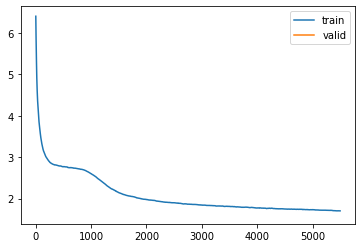

In [ ]:
learn.recorder.plot_loss()